# UPDATES

1. Using absolute angles 
2. This locks th_body
3. This includes the motor interia only:

### NB!!!!
Should the body rotation be included, the inertia of motor need to account for the body rotation as well dth_rotor = dth_body + dUL * N_GR


### Side Notes
1. Calculation of motor inertia (https://github.com/yangmingustb/planning_books_1/blob/master/Lynch%20%E5%92%8C%20Park%20-%202017%20-%20Modern%20robotics%20mechanics%2C%20planning%2C%20and%20control.pdf)
2. Remember to remove y_mat from y_boomOffset 
3. Does not use SAA for the angular velocity of the boom
4. Need to correctly estimate length_COM_LL (at different angle to length_LL)
5. Includes offsets of ybody, yboom, xfoot and account for LR com and LR length at different angles (angle_offset). Note: theta_LR is the angle to COM whereas theta_LR - angle_offset is the angle to connection link
6. The foot placement has been adjusted
7. Use video to check inertia values and angular velocities (https://www.youtube.com/watch?v=QE1_H2vtHLU&t=176s)

In [1]:
%reset

import sympy as sym
import numpy as np
import pickle as pickle

sym.init_printing()
from IPython.display import display

#symbols
legs = ['A','B']
links = ['UL','LL','UR','LR','sfoot'] #upper left link, lower left link etc etc
bases = ['body','boom']

Once deleted, variables cannot be recovered. Proceed (y/[n])? y


In [2]:
#Parameters
masses = {}
lengths = {}
lengths_COM = {}
inertias = {}

g = sym.symbols('g')
N_GR = sym.symbols('N_GR') # gear ratio

# boom parameters
lx_boom = sym.symbols('lx_boom')
lx_boom_COM = sym.symbols('lx_boom_COM')
ly_boom = sym.symbols('ly_boom')
ly_boom_COM = sym.symbols('ly_boom_COM')
y_boomOffset = sym.symbols('y_boomOffset')
K_spring = sym.symbols('K_spring')
B_damper = sym.symbols('B_damper')

lx_boom_bodyCOM = sym.symbols('lx_boom_bodyCOM')
ly_boom_bodyCOM_y = sym.symbols('ly_boom_bodyCOM_y')

# body parameters
yBO = sym.symbols('yBO') # y body offset
xBO = sym.symbols('xBO') # from COM of body upper link distance (x)
foot_length = sym.symbols('foot_length')
foot_angle = sym.symbols('foot_angle') 
angle_offset = sym.symbols('angle_offset') # this angle gets added to connection point and foot position of LR link as COM and connection point of LR are at different angles

for leg in legs:
    for link in links:   
        masses.update({(link,leg): sym.symbols('m_{0}'.format(link+leg))})
        lengths.update({(link,leg): sym.symbols('l_{0}'.format(link+leg))})
        lengths_COM.update({(link,leg): sym.symbols('l_COM_{0}'.format(link+leg))})
        inertias.update({(link,leg): sym.symbols('In_{0}'.format(link+leg))})
        
for base in bases:
    masses.update({(base): sym.symbols('m_{0}'.format(base))})
    lengths.update({(base): sym.symbols('l_{0}'.format(base))})
    if base == 'boom':
        inertias.update({(base,'X'): sym.symbols('In_{0}_X'.format(base))})
        inertias.update({(base,'Y'): sym.symbols('In_{0}_Y'.format(base))})
    else:
        inertias.update({(base): sym.symbols('In_{0}'.format(base))})
        
inertias.update({('motors'): sym.symbols('In_motors')})
    
# gen coordinates
body_co = ['xb','yb']
xb,yb = sym.symbols(['xb','yb'])
dxb,dyb = sym.symbols(['\dot{xb}','\dot{yb}'])
ddxb,ddyb = sym.symbols(['\ddot{xb}','\ddot{yb}'])

th = {}
dth = {}
ddth = {}

for leg in legs:
    for link in links:
        th.update({(link,leg): sym.symbols('theta_{0}'.format(link+leg))}) 
        dth.update({(link,leg): sym.symbols('\dot{{\\theta}}_{{{0}}}'.format(link+leg))})
        ddth.update({(link,leg): sym.symbols('\ddot{{\\theta}}_{{{0}}}'.format(link+leg))})

In [3]:
q = sym.Matrix([xb]+[yb]+[th[link,leg] for leg in legs for link in links])
dq = sym.Matrix([dxb]+[dyb]+[dth[link,leg] for leg in legs for link in links])
ddq = sym.Matrix([ddxb]+[ddyb]+[ddth[link,leg] for leg in legs for link in links])

In [4]:
q,dq,ddq

⎛⎡   xb   ⎤  ⎡      \dot{xb}       ⎤  ⎡      \ddot{xb}       ⎤⎞
⎜⎢        ⎥  ⎢                     ⎥  ⎢                      ⎥⎟
⎜⎢   yb   ⎥  ⎢      \dot{yb}       ⎥  ⎢      \ddot{yb}       ⎥⎟
⎜⎢        ⎥  ⎢                     ⎥  ⎢                      ⎥⎟
⎜⎢ θ_ULA  ⎥  ⎢ \dot{\theta}_{ULA}  ⎥  ⎢ \ddot{\theta}_{ULA}  ⎥⎟
⎜⎢        ⎥  ⎢                     ⎥  ⎢                      ⎥⎟
⎜⎢ θ_LLA  ⎥  ⎢ \dot{\theta}_{LLA}  ⎥  ⎢ \ddot{\theta}_{LLA}  ⎥⎟
⎜⎢        ⎥  ⎢                     ⎥  ⎢                      ⎥⎟
⎜⎢ θ_URA  ⎥  ⎢ \dot{\theta}_{URA}  ⎥  ⎢ \ddot{\theta}_{URA}  ⎥⎟
⎜⎢        ⎥  ⎢                     ⎥  ⎢                      ⎥⎟
⎜⎢ θ_LRA  ⎥  ⎢ \dot{\theta}_{LRA}  ⎥  ⎢ \ddot{\theta}_{LRA}  ⎥⎟
⎜⎢        ⎥, ⎢                     ⎥, ⎢                      ⎥⎟
⎜⎢θ_sfootA⎥  ⎢\dot{\theta}_{sfootA}⎥  ⎢\ddot{\theta}_{sfootA}⎥⎟
⎜⎢        ⎥  ⎢                     ⎥  ⎢                      ⎥⎟
⎜⎢ θ_ULB  ⎥  ⎢ \dot{\theta}_{ULB}  ⎥  ⎢ \ddot{\theta}_{ULB}  ⎥⎟
⎜⎢        ⎥  ⎢                     ⎥  ⎢ 

In [5]:
r_bases = {}
r_links = {}

# position to COM of each link - where the mass is approximated to be
r_bases.update({'body': sym.Matrix([xb,
                                    yb])})

'''
TOP VIEW
x
^
+>y

GIVEN:
r_link('boom_x') = xb - lx_boom_COM_x
sin(thx) = xb/(lx_boom+lx_boom_bodyCOM)
sin(thx) = lx_boom_COM_x/lx_boom_COM

SIMPLIFY:
xb/(lx_boom+lx_boom_bodyCOM) = lx_boom_COM_x/lx_boom_COM
lx_boom_COM_x = (xb/(lx_boom+lx_boom_bodyCOM)) * lx_boom_COM

r_link('boom_x') = xb - (xb/(lx_boom+lx_boom_bodyCOM)) * lx_boom_COM

SIDE VIEW
y
^
+>x

GIVEN:
yb = y_boomOffset + ly_boom_y + ly_boom_bodyCOM_y

r_link('boom_y') = yb - y_boomOffset - ly_boom_COM_y

sin(thy) = (yb-y_boomOffset-ly_boom_bodyCOM_y)/(ly_boom)
sin(thy) = ly_boom_COM_y/ly_boom_COM

SIMPLIFY:
ly_boom_COM_y/ly_boom_COM = (yb-y_boomOffset-ly_boom_bodyCOM_y)/(ly_boom)
ly_boom_COM_y = ((yb-y_boomOffset-ly_boom_bodyCOM_y)*(ly_boom_COM))/(ly_boom)

r_link('boom_y') = yb - y_boomOffset -  ((yb-y_boomOffset-ly_boom_bodyCOM_y)*(ly_boom_COM))/(ly_boom)
'''

r_bases.update({'boom': sym.Matrix([xb - (xb/(lx_boom+lx_boom_bodyCOM)) * lx_boom_COM,
                                    yb - y_boomOffset - ((yb-y_boomOffset-ly_boom_bodyCOM_y)*(ly_boom_COM))/(ly_boom)])})

for leg in legs:
    r_links.update({('UL',leg): sym.Matrix([xb-xBO-lengths_COM['UL',leg]*sym.cos(th['UL',leg]),
                                            yb-yBO-lengths_COM['UL',leg]*sym.sin(th['UL',leg])])})
    
    r_links.update({('UR',leg): sym.Matrix([xb+xBO+lengths_COM['UR',leg]*sym.cos(np.pi - th['UR',leg]),
                                            yb-yBO-lengths_COM['UR',leg]*sym.sin(np.pi - th['UR',leg])])})
    
    r_links.update({('LL',leg): sym.Matrix([xb-xBO-lengths['UL',leg]*sym.cos(th['UL',leg]) + lengths_COM['LL',leg]*sym.cos(np.pi - th['LL',leg]),
                                            yb-yBO-lengths['UL',leg]*sym.sin(th['UL',leg]) - lengths_COM['LL',leg]*sym.sin(np.pi - th['LL',leg])])})
    
    r_links.update({('LR',leg): sym.Matrix([xb+xBO+lengths['UR',leg]*sym.cos(np.pi - th['UR',leg]) - lengths_COM['LR',leg]*sym.cos(th['LR',leg]),
                                            yb-yBO-lengths['UR',leg]*sym.sin(np.pi - th['UR',leg]) - lengths_COM['LR',leg]*sym.sin(th['LR',leg])])})
    
    if leg == 'A':
        r_links.update({('sfoot',leg): sym.Matrix([xb+xBO+lengths['UR',leg]*sym.cos(np.pi - th['UR',leg]) - lengths['LR',leg]*sym.cos(th['LR',leg]-angle_offset) + (foot_length+q[6])*sym.cos(foot_angle - th['LR',leg] - angle_offset),
                                                   yb-yBO-lengths['UR',leg]*sym.sin(np.pi - th['UR',leg]) - lengths['LR',leg]*sym.sin(th['LR',leg]-angle_offset) - (foot_length+q[6])*sym.sin(foot_angle - th['LR',leg] - angle_offset)])})
                                
    else:
        r_links.update({('sfoot',leg): sym.Matrix([xb+xBO+lengths['UR',leg]*sym.cos(np.pi - th['UR',leg]) - lengths['LR',leg]*sym.cos(th['LR',leg]-angle_offset) + (foot_length+q[-1])*sym.cos(foot_angle - th['LR',leg] - angle_offset),
                                                   yb-yBO-lengths['UR',leg]*sym.sin(np.pi - th['UR',leg]) - lengths['LR',leg]*sym.sin(th['LR',leg]-angle_offset) - (foot_length+q[-1])*sym.sin(foot_angle - th['LR',leg] - angle_offset)])})
        

In [6]:
r_links['sfoot','A']

⎡-l_LRA⋅cos(angle_offset - θ_LRA) + l_URA⋅cos(θ_URA - 3.14159265358979) + xBO 
⎢                                                                             
⎣l_LRA⋅sin(angle_offset - θ_LRA) + l_URA⋅sin(θ_URA - 3.14159265358979) - yBO +

+ xb + (foot_length + θ_sfootA)⋅cos(angle_offset - foot_angle + θ_LRA)⎤
                                                                      ⎥
 yb + (foot_length + θ_sfootA)⋅sin(angle_offset - foot_angle + θ_LRA) ⎦

In [7]:
r_links['sfoot','B']

⎡-l_LRB⋅cos(angle_offset - θ_LRB) + l_URB⋅cos(θ_URB - 3.14159265358979) + xBO 
⎢                                                                             
⎣l_LRB⋅sin(angle_offset - θ_LRB) + l_URB⋅sin(θ_URB - 3.14159265358979) - yBO +

+ xb + (foot_length + θ_sfootB)⋅cos(angle_offset - foot_angle + θ_LRB)⎤
                                                                      ⎥
 yb + (foot_length + θ_sfootB)⋅sin(angle_offset - foot_angle + θ_LRB) ⎦

In [8]:

dr_links = {}
dr_bases = {}
w_links = {}
w_bases = {}

for leg in legs:
    for link in links:
        dr_links.update({(link,leg): r_links[link,leg].jacobian(q)*dq})
        
for base in bases:
    dr_bases.update({base: r_bases[base].jacobian(q)*dq})
    
thx_boom = sym.Matrix([sym.asin(xb/(lx_boom+lx_boom_bodyCOM))])
thy_boom = sym.Matrix([sym.asin((yb-y_boomOffset-ly_boom_bodyCOM_y)/(ly_boom))])
dthx_boom = thx_boom.jacobian(q)*dq
dthy_boom = thy_boom.jacobian(q)*dq
w_bases.update({('boom','dthx_boom'): dthx_boom[0]})
w_bases.update({('boom','dthy_boom'): dthy_boom[0]})

for leg in legs:
    w_links.update({('UL',leg): dth['UL',leg]})
    w_links.update({('LL',leg): dth['LL',leg]})
    w_links.update({('UR',leg): dth['UR',leg]})
    w_links.update({('LR',leg): dth['LR',leg]})
    w_links.update({('sfoot',leg): dth['sfoot',leg]})
    

In [9]:
T_bases = {}
T_links = {}
V_bases = {}
V_links = {}
T_motors = {}

# Mass Vectors
Mbody = sym.Matrix([[masses['body'],masses['body']]])
Mboom = sym.Matrix([[masses['boom'],masses['boom']]])

# Kinetic Energy
T_bases.update({'body': 0.5*Mbody*sym.matrix_multiply_elementwise(dr_bases['body'],dr_bases['body'])})
T_bases.update({'boom': 0.5*Mboom*sym.matrix_multiply_elementwise(dr_bases['boom'],dr_bases['boom']) + sym.Matrix([[0.5*w_bases['boom','dthx_boom']*w_bases['boom','dthx_boom']*inertias['boom','X']]]) + sym.Matrix([[0.5*w_bases['boom','dthy_boom']*w_bases['boom','dthy_boom']*inertias['boom','Y']]])})

# Potential Energy
for base in bases:
    if base == 'body':
        V_bases.update({base: masses[base]*g*r_bases[base][1]})
    else:
        V_bases.update({base: masses[base]*g*(y_boomOffset+((yb-y_boomOffset-ly_boom_bodyCOM_y)*(ly_boom_COM))/(ly_boom))})

# T_bases.update({'motors': N_motors*0.5*sym.Matrix([[w_bases['boom','dthx_boom']*w_bases['boom','dthx_boom']*inertias['boom','X']]])})

for leg in legs:    
    for link in links:

            T_links.update({(link,leg): 0.5*sym.Matrix([[masses[link,leg],masses[link,leg]]])*sym.matrix_multiply_elementwise(dr_links[link,leg],dr_links[link,leg]) + sym.Matrix([[0.5*w_links[link,leg]*w_links[link,leg]*inertias[link,leg]]])})
            
            if 'sfoot' in link:
                if leg == 'A':
                    V_links.update({(link,leg): (masses[link,leg]*g*r_links[link,leg][1]) + 0.5*K_spring*q[6]**2})
                else:
                    V_links.update({(link,leg): (masses[link,leg]*g*r_links[link,leg][1]) + 0.5*K_spring*q[-1]**2})
            else:
                V_links.update({(link,leg): masses[link,leg]*g*r_links[link,leg][1]})
        
            #### NEED TO USE RELATIVE ANGLE
            if 'U' in link:
                T_motors.update({(link,leg):0.5*(N_GR**2)*sym.Matrix([[w_links[link,leg]*w_links[link,leg]*inertias['motors']]])})
            else:
                pass

Ttot = T_bases['body'] + T_bases['boom']
Vtot = V_bases['body'] + V_bases['boom']
    
for leg in legs:
    for link in links:
        Ttot = Ttot + T_links[link,leg] 
        Vtot = Vtot + V_links[link,leg] 
        if 'U' in link:
            Ttot = Ttot + T_motors[link,leg] 
        else:
            pass
        
Ttot = Ttot[0]

In [10]:
print(V_links['sfoot','A'])
print(T_links['sfoot','B'])

0.5*K_spring*theta_sfootA**2 + g*m_sfootA*(l_LRA*sin(angle_offset - theta_LRA) + l_URA*sin(theta_URA - 3.14159265358979) - yBO + yb + (foot_length + theta_sfootA)*sin(angle_offset - foot_angle + theta_LRA))
Matrix([[0.5*In_sfootB*\dot{\theta}_{sfootB}**2 + 0.5*m_sfootB*(\dot{\theta}_{LRB}*(-l_LRB*sin(angle_offset - theta_LRB) - (foot_length + theta_sfootB)*sin(angle_offset - foot_angle + theta_LRB)) - \dot{\theta}_{URB}*l_URB*sin(theta_URB - 3.14159265358979) + \dot{\theta}_{sfootB}*cos(angle_offset - foot_angle + theta_LRB) + \dot{xb})**2 + 0.5*m_sfootB*(\dot{\theta}_{LRB}*(-l_LRB*cos(angle_offset - theta_LRB) + (foot_length + theta_sfootB)*cos(angle_offset - foot_angle + theta_LRB)) + \dot{\theta}_{URB}*l_URB*cos(theta_URB - 3.14159265358979) + \dot{\theta}_{sfootB}*sin(angle_offset - foot_angle + theta_LRB) + \dot{yb})**2]])


In [11]:
# Manipulator Equation (M*ddq + C + G = Tau + Q)

# M Matrix
M = sym.zeros(len(q),len(q))

for i in range(len(q)):
    for j in range(len(q)):
        M[i,j] = sym.diff(sym.diff(Ttot,dq[i]),dq[j])

M = sym.simplify(M)

M_size = int(np.sqrt(len(M))) # assumes square matrix (len(M) = 4x4 = 16)

dM = sym.zeros(M_size,M_size)

for i in range(M_size):
    for j in range(M_size):
        dM[i,j] = sym.Matrix([M[i,j]]).jacobian(q)*dq

# C Matrix
C = dM*dq - (sym.Matrix([Ttot]).jacobian(q)).transpose() # 4x1 - 1x4^Transpose

# G Matrix
G = (sym.Matrix([Vtot]).jacobian(q)).transpose() # 4x1

tau = {}
lamda = {}
GRF = {}

connect_position = {}
foot_position = {}

Jbn = {}
Jfoot = {}
lamda_GRF = {}
lamda_connect = {}

Tau = sym.Matrix([])
for bc in range(len(body_co)):
    Tau = Tau.col_join(sym.Matrix([[0]]))
    
R = sym.Matrix([])
for bc in range(len(body_co)):
    R = R.col_join(sym.Matrix([[0]]))

Q = sym.zeros(len(q),1)

for leg in legs:
    tau.update({('left',leg): sym.symbols('tau_left{0}'.format(leg))})
    tau.update({('right',leg): sym.symbols('tau_right{0}'.format(leg))})
    
    lamda.update({('x',leg): sym.symbols('lamda_x{0}'.format(leg))})
    lamda.update({('y',leg): sym.symbols('lamda_y{0}'.format(leg))})
    
    GRF.update({('x',leg): sym.symbols('GRF_x{0}'.format(leg))})
    GRF.update({('y',leg): sym.symbols('GRF_y{0}'.format(leg))})
    

    connect_position.update({('left',leg): sym.Matrix([xb-xBO-lengths['UL',leg]*sym.cos(th['UL',leg]) + lengths['LL',leg]*sym.cos(np.pi - th['LL',leg]),
                                                       yb-yBO-lengths['UL',leg]*sym.sin(th['UL',leg]) - lengths['LL',leg]*sym.sin(np.pi - th['LL',leg])])})
    
    connect_position.update({('right',leg): sym.Matrix([xb+xBO+lengths['UR',leg]*sym.cos(np.pi - th['UR',leg]) - lengths['LR',leg]*sym.cos(th['LR',leg]-angle_offset),
                                                        yb-yBO-lengths['UR',leg]*sym.sin(np.pi - th['UR',leg]) - lengths['LR',leg]*sym.sin(th['LR',leg]-angle_offset)])})
    

       
#     r = {}
#     Φ = {}
#     JpolarT = {}
#     temp ={}

#     L1 = lengths['UL',leg]
#     L2 = lengths['UR',leg]
#     L3 = lengths['LR',leg]
#     L4 = lengths['LL',leg]
#     L6 = foot_length
#     mu = foot_angle

#     q1 = th['UL',leg] 
#     q2 = th['UR',leg] 

#     dq1 = dth['UL',leg]
#     dq2 = dth['UR',leg]

#     B1 = sym.Matrix([xb - xBO - L1*sym.cos(q1),
#                     yb-yBO - L1*sym.sin(q1)])
#     B2 = sym.Matrix([xb + xBO  + L2*sym.cos(np.pi-q2),
#                     yb-yBO - L2*sym.sin(np.pi-q2)])

#     a = sym.sqrt((B1[0] - B2[0])**2)
#     b =  B1[1] - B2[1]
#     B12 = sym.sqrt(a**2 + b**2)
#     alpha = sym.atan(b,a)
#     beta = sym.acos( ((L4)**2 - (B12)**2 - (L3)**2)/(-2*(B12)*(L3)) )
#     q3 = alpha + beta

#     c = (L3**2 + L6**2 - 2*L3*L6*sym.cos(mu))**0.5 
#     lamda_temp = sym.asin(L6*(sym.sin(mu)/c))

#     X_foot = xb + xBO + L2*sym.cos(np.pi-q2) - c*sym.cos(q3+lamda_temp)
#     Y_foot = L2*sym.sin(np.pi-q2) + c*sym.sin(q3+lamda_temp)

#     r.update({(leg): ((X_foot)**2 + (Y_foot)**2)}) 
#     Φ.update({(leg): (np.pi/2 - sym.atan(Y_foot/X_foot))}) 

#     JpolarT.update({(leg): sym.Matrix([r[leg],Φ[leg]]).jacobian(sym.Matrix([q1,q2])).transpose()})
    
#     temp.update({(leg): alpha})
  
    if leg == 'A':
        foot_position.update({(leg): sym.Matrix([connect_position['right',leg][0] + (foot_length+q[6])*sym.cos(foot_angle - th['LR',leg] - angle_offset),
                                                 connect_position['right',leg][1] - (foot_length+q[6])*sym.sin(foot_angle - th['LR',leg] - angle_offset)])})
    else:
        foot_position.update({(leg): sym.Matrix([connect_position['right',leg][0] + (foot_length+q[-1])*sym.cos(foot_angle - th['LR',leg] - angle_offset),
                                                 connect_position['right',leg][1] - (foot_length+q[-1])*sym.sin(foot_angle - th['LR',leg] - angle_offset)])})
        
    
#     foot_position.update({(leg): sym.Matrix([connect_position['right',leg][0] + foot_length*sym.cos(foot_angle - th['LR',leg] - angle_offset),
#                                              connect_position['right',leg][1] - foot_length*sym.sin(foot_angle - th['LR',leg] - angle_offset)])})
    
    
    Jbn.update({('left',leg): connect_position['left',leg].jacobian(q)})                    
    Jbn.update({('right',leg): connect_position['right',leg].jacobian(q)}) 
    
    Jfoot.update({(leg): foot_position[leg].jacobian(q)})
    
    lamda_GRF.update({(leg): sym.Matrix([[GRF['x',leg]],[GRF['y',leg]]])})
    
    lamda_connect.update({('left',leg): sym.Matrix([[-lamda['x',leg]],[-lamda['y',leg]]])})
    lamda_connect.update({('right',leg): sym.Matrix([[lamda['x',leg]],[lamda['y',leg]]])})
    
    Tau = Tau.col_join(sym.Matrix([[tau['left',leg]],[0],[tau['right',leg]],[0],[0]]))
    
    if leg == 'A':
        R  = R.col_join(sym.Matrix([[0],[0],[0],[0],[B_damper*dq[6]]]))
    else:
        R  = R.col_join(sym.Matrix([[0],[0],[0],[0],[B_damper*dq[-1]]]))
        
    Q = Q + (Jfoot[leg].transpose()*lamda_GRF[leg]) + (Jbn['left',leg].transpose()*lamda_connect['left',leg]) + (Jbn['right',leg].transpose()*lamda_connect['right',leg])

In [12]:
foot_position

{'A': Matrix([
 [-l_LRA*cos(angle_offset - theta_LRA) + l_URA*cos(theta_URA - 3.14159265358979) + xBO + xb + (foot_length + theta_sfootA)*cos(angle_offset - foot_angle + theta_LRA)],
 [ l_LRA*sin(angle_offset - theta_LRA) + l_URA*sin(theta_URA - 3.14159265358979) - yBO + yb + (foot_length + theta_sfootA)*sin(angle_offset - foot_angle + theta_LRA)]]),
 'B': Matrix([
 [-l_LRB*cos(angle_offset - theta_LRB) + l_URB*cos(theta_URB - 3.14159265358979) + xBO + xb + (foot_length + theta_sfootB)*cos(angle_offset - foot_angle + theta_LRB)],
 [ l_LRB*sin(angle_offset - theta_LRB) + l_URB*sin(theta_URB - 3.14159265358979) - yBO + yb + (foot_length + theta_sfootB)*sin(angle_offset - foot_angle + theta_LRB)]])}

In [13]:
# Manipulator Equation 
EOM = M*ddq + G + C - Tau - Q - R

In [14]:
EOMs = sym.zeros(len(q),1)
for j in range(len(q)):
    EOMs[j] = EOM[j].simplify()
    print('j = {0} is done'.format(j+1))
    #dill.dump_session('Biped_th0_ImotorsV2_iteration_{0}.db'.format(j+1))

j = 1 is done
j = 2 is done
j = 3 is done
j = 4 is done
j = 5 is done
j = 6 is done
j = 7 is done
j = 8 is done
j = 9 is done
j = 10 is done
j = 11 is done
j = 12 is done


In [15]:
import dill
dill.dump_session('EOM_V3.db')

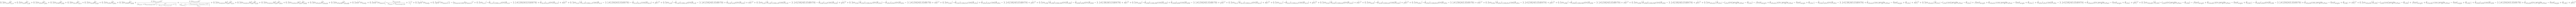

In [16]:
Ttot